EDA

In [607]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
% matplotlib inline
from geopy.distance import vincenty
from datetime import datetime, timedelta
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier 
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


df = pd.read_csv('Crimes_-_2001_to_present.csv')

df.shape

df = df[df['Year'] <= 2016]

len(df['Year'])

df['Year'].value_counts()

def dummy(domestic):   
    try: 
        if domestic == False:
            return 0
        else: 
            return 1
    except:
        pass
    
df['domestic_dummied'] = df['Domestic'].apply(dummy)
df['Arrest_Dummied'] = df['Arrest'].apply(dummy)

df.drop('FBI Code', axis=1, inplace = True)
df.drop('Updated On', axis=1, inplace = True)
df.drop('Primary Type', axis=1, inplace = True)
df.drop('IUCR', axis=1, inplace= True)
df.drop('X Coordinate', axis=1, inplace= True)
df.drop('Y Coordinate', axis=1, inplace= True)
df.drop('Location', axis=1, inplace= True)
df.drop('Block', axis=1, inplace= True)

df.dropna(subset=['Latitude', 'Longitude'], how='all', inplace=True)

df['Location Description'].fillna('RESIDENCE', inplace=True)

df['District'].dropna(how='all', inplace=True)

df['District'].replace(' ', np.nan, inplace=True)

df.dropna(subset=['District'], inplace=True)

police_stations = pd.read_csv('Police_Stations.csv')

def distance_from_police_station(lon, lat):
    min_dist = None
    for coord in zip(police_stations['LONGITUDE'].values, police_stations['LATITUDE'].values):
        if min_dist is None:
            min_dist = vincenty((lon, lat), coord, ellipsoid='WGS-84').miles
        else:
            dist =  vincenty((lon, lat), coord, ellipsoid='WGS-84').miles
            if dist < min_dist:
                min_dist = dist
    return min_dist

df['nearest_police_station'] = df.apply(lambda x: distance_from_police_station(x['Longitude'], x['Latitude']), axis=1)

chicago_campuses = pd.read_csv('ChicagoCampusCentralAddress.csv')

chicago_campuses.dropna(how='all', inplace=True)

def distance_from_campus(lon, lat):
    min_dist = None
    for coord in zip(chicago_campuses['Longitude'].values, chicago_campuses['Latitude'].values):
        if min_dist is None:
            min_dist = vincenty((lon, lat), coord, ellipsoid='WGS-84').miles
        else:
            dist =  vincenty((lon, lat), coord, ellipsoid='WGS-84').miles
            if dist < min_dist:
                min_dist = dist
    return min_dist

df['nearest_campus'] = df.apply(lambda x: distance_from_campus(x['Longitude'], x['Latitude']), axis=1)

df.loc[df['nearest_campus'].idxmax()]

df[df['ID']== 6169464]

df.drop([4049], inplace=True)

df.loc[df['nearest_campus'].idxmax()]

df.loc[df['nearest_campus'].idxmin()]

df.groupby('Community Area')['Case Number'].nunique()

def assign(community):
    if community == 0:
        return int(56)
    else:
        return community


df['Community Area'] = df['Community Area'].apply(assign)

df.dropna(subset=['Community Area'], how ='all', inplace =True)

df.dropna(subset=['Ward'], how='all', inplace=True)

df['Community Area'] = df['Community Area'].astype(int)
df['Ward'] = df['Ward'].astype(int)
df['District'] = df['District'].astype(int)

df['date_transformed']= pd.to_datetime(df['Date'])
df['time_full'] = df['date_transformed'].apply(lambda x: datetime.strftime(x, "%H:%M"))
df['time_hour'] = df['date_transformed'].apply(lambda x: int(datetime.strftime(x, "%H")))
df['Day_of_Month'] = df['date_transformed'].apply(lambda x: int(datetime.strftime(x, "%d")))
df['Month'] = df['date_transformed'].apply(lambda x: int(datetime.strftime(x, "%m")))
df['Day_of_Week'] = df['date_transformed'].apply(lambda x: datetime.strftime(x, "%A"))

def categorize(crime): 
    if 'ATTEMPT NON-AGGRAVATED' in crime:
        crime = 'ATTEMPT NON-AGGRAVATED'
    elif 'NON-AGGRAVATED' in crime:
        crime = 'NON-AGGRAVATED'
    elif 'AGGRAVATED' in crime:
         crime = 'AGGRAVATED'
    elif 'ATTEMPT AGG' in crime:
        crime = 'ATTEMPT-AGGRAVATED'
    elif 'PREDATORY' in crime:
        crime = 'PREDATORY'
    else:
         crime = crime
    return crime

df['Description_Transformed'] = df['Description'].apply(categorize)

df.groupby('Description_Transformed')['Arrest'].sum().sort_values()

description_dummies = pd.get_dummies(df['Description_Transformed'])

def define(location):
    if 'RESIDENCE' in location:
        location = 'Residential Property'
    elif 'CHA' in location:
        location = 'Public Housing'
    elif 'APARTMENT' in location:
        location = 'Residential Property'
    elif 'RESIDENTIAL' in location:
        location = 'Residential Property'
    elif 'BARBER' in location:
        location = 'Business'
    elif 'BUSINESS' in location:
        location = 'Business'
    elif 'RETAIL' in location:
        location = 'Business'
    elif 'GAS' in location:
        location = 'Business'
    elif 'RESTAURANT' in location:
        location = 'Business'
    elif 'BAR' in location:
        location = 'Business'
    elif 'TAVERN' in location:
        location = 'Business'
    elif 'WAREHOUSE' in location:
        location = 'Business'
    elif 'STORE' in location:
        location = 'Business'
    elif 'OFFICE' in location:
        location = 'Business'
    elif 'THEATER' in location:
        location = 'Business'
    elif 'CLUB' in location:
        location = 'Business'
    elif 'BANK' in location:
        location = 'Business'
    elif 'FACTORY' in location:
        location = 'Business'
    elif 'ANIMAL' in location:
        location = 'Business'
    elif 'CAR WASH' in location:
        location = 'Business'
    elif 'HOTEL' in location:
        location = 'Business'
    elif 'STREET' in location:
        location = 'Public'
    elif 'ALLEY' in location:
        location = 'Public'
    elif 'SIDEWALK' in location:
        location = 'Public'
    elif 'LAKEFRONT' in location:
        location = 'Public'
    elif 'PARK' in location:
        location = 'Public'
    elif 'NON-RESIDENTIAL' in location:
        location = 'Public'
    elif 'BRIDGE' in location:
        location = "Public"
    elif 'SCHOOL' in location:
        location = 'School'
    elif 'COLLEGE' in location:
        location = 'School'
    elif 'HOSPITAL' in location:
        location = 'Care Facility'
    elif 'NURSING' in location:
        location = 'Care Facility'
    elif 'DAY CARE' in location:
        location = 'Care Facility'
    elif 'CTA' in location:
        location = 'Public Transportation'
    elif 'TAXI' in location:
        location = 'Public Transportation'
    elif 'RIDE SERVICE' in location:
        location = 'Public Transportation'
    elif 'RAILROAD' in location:
        location = 'Public Transportation'
    elif 'AIRPORT' in location:
        location = 'Public Transportation'
    elif 'VEHICLE NON' in location:
        location = 'Private Vehicle'
    elif 'BOAT' in location:
        location = 'Private Vehicle'
    elif 'ABANDON' in location:
        location = 'Vacant Property'
    elif 'VACANT' in location:
        location = 'Vacant Property'
    else:
        location = 'Other'
    return location   

df['location_transformed'] = df['Location Description'].apply(define)

df.groupby('location_transformed')['Arrest'].sum().sort_values()

df.groupby('Community Area')['Arrest'].sum().sort_values()
df.groupby('District')['Arrest_Dummied'].sum().sort_values()
df.groupby('Ward')['Arrest_Dummied'].sum().sort_values()

location_dummies = pd.get_dummies(df['location_transformed'])
description_dummies = pd.get_dummies(df['Description_Transformed'])
ward_dummies = pd.get_dummies(df['Ward'], prefix='ward')
district_dummies = pd.get_dummies(df['District'], prefix='district')
beat_dummies = pd.get_dummies(df['Beat'], prefix='beat')
community_dummies = pd.get_dummies(df['Community Area'], prefix='community')
weekday_dummies = pd.get_dummies(df['Day_of_Week'])

#without 'Beat'
dfwd = pd.concat([df, location_dummies, description_dummies, ward_dummies, district_dummies, community_dummies, weekday_dummies], axis=1)

dfwd.drop('ID', axis=1, inplace = True)
dfwd.drop('Case Number', axis=1, inplace = True)
dfwd.drop('Description', axis=1, inplace = True)
dfwd.drop('Location Description', axis=1, inplace = True)
dfwd.drop('Domestic', axis=1, inplace = True)
dfwd.drop('Arrest', axis=1, inplace = True)
dfwd.drop('Latitude', axis=1, inplace = True)
dfwd.drop('Longitude', axis=1, inplace = True)
dfwd.drop('Date', axis=1, inplace = True)
dfwd.drop('Beat', axis=1, inplace = True)
dfwd.drop('District', axis=1, inplace = True)
dfwd.drop('Ward', axis=1, inplace = True)
dfwd.drop('Community Area', axis=1, inplace = True)
dfwd.drop('location_transformed', axis=1, inplace=True)
dfwd.drop('Description_Transformed', axis=1, inplace=True)
dfwd.drop('date_transformed', axis=1, inplace=True)
dfwd.drop('Day_of_Week', axis=1, inplace=True)
dfwd.drop('time_full', axis=1, inplace=True)

dfwd.shape
dfwd.columns




Index([u'Year', u'domestic_dummied', u'Arrest_Dummied',
       u'nearest_police_station', u'nearest_campus', u'time_hour',
       u'Day_of_Month', u'Month', u'Business', u'Care Facility',
       ...
       u'community_75', u'community_76', u'community_77', u'Friday', u'Monday',
       u'Saturday', u'Sunday', u'Thursday', u'Tuesday', u'Wednesday'],
      dtype='object', length=179)

MODELING

In [667]:
y = dfwd['Arrest_Dummied']
# x = dfwd.drop('Arrest_Dummied', axis =1)
x = dfwd[['nearest_police_station', 'Year', 'nearest_campus',
       'NON-AGGRAVATED', 'time_hour', 'Day_of_Month', 'Month',
       'PREDATORY', 'Residential Property', 'domestic_dummied',
       'AGGRAVATED', 'Public', 'ATTEMPT-AGGRAVATED', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']]

In [668]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [669]:
def run_model(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    print "base model score: ", np.mean(y_train)   #the proportion of 1's (aka arrests)
    print "other base model score: ", 1-np.mean(y_train)   #the proportion of 0's (aka non-arrests)
    print "training score:   ", model.score(x_train, y_train)
    print "test score:       ", model.score(x_test, y_test)

In [670]:
rfc = RandomForestClassifier(class_weight = "balanced", min_samples_leaf =6, n_estimators=30)
rfcb = BaggingClassifier(base_estimator =rfc)
et = ExtraTreesClassifier(class_weight= "balanced", min_samples_leaf =3, n_estimators=40)
xgb = XGBClassifier()
gbc = GradientBoostingClassifier(min_samples_leaf=3)
lr = LogisticRegression(class_weight="balanced")
lrb = BaggingClassifier(base_estimator=lr)
vc= VotingClassifier(estimators = [('Bagged LR', lrb),('XGBoost', xgb), ('Gradient Boost', gbc), ('RFC', rfc), ('bagged rfc', rfcb), ('ET', et), ('LR', lr)], voting = "soft")
vc2 = VotingClassifier(estimators = [('Bagged LR', lrb), ('Gradient Boost', gbc), ('RFC', rfc), ('bagged rfc', rfcb), ('ET', et), ('LR', lr)], voting = "soft")
vc3 = VotingClassifier(estimators = [('Bagged LR', lrb), ('RFC', rfc), ('bagged rfc', rfcb), ('ET', et), ('LR', lr)], voting = "soft")
vc4 = VotingClassifier(estimators = [('Bagged LR', lrb), ('RFC', rfc), ('bagged rfc', rfcb), ('ET', et)], voting = "soft")
vc5 = VotingClassifier(estimators = [('RFC', rfc), ('bagged rfc', rfcb), ('ET', et)], voting = "soft")
vc6 = VotingClassifier(estimators = [('Bagged LR', lrb), ('RFC', rfc), ('bagged rfc', rfcb)], voting = "soft")

In [909]:
models = [rfc, rfcb, vc, vc2, vc3, vc4, vc5, vc6]
for i in models:
    print "\n"
    print i
    run_model(x_train, y_train, x_test, y_test, i)



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
base model score:  0.159958180868
other base model score:  0.840041819132
training score:    0.841152639833
test score:        0.755978047824


BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         bootstrap

In [691]:
def classifications(y_test, y_predict):
    print 'Mean accuracy score %s ' % accuracy_score(y_test, y_predict), '\n'
    print confusion_matrix(y_test, y_predict), '\n'
    print classification_report(y_test, y_predict)

In [692]:
print "Reports for Random Forest:\t", classifications(y_test, rfc.predict(x_test))

Reports for Random Forest:	Mean accuracy score 0.749117992944  

[[3513  800]
 [ 480  309]] 

             precision    recall  f1-score   support

          0       0.88      0.81      0.85      4313
          1       0.28      0.39      0.33       789

avg / total       0.79      0.75      0.77      5102

None


In [733]:
rfc_y_pred = rfc.predict(x_test)
rfc_cm = np.array(confusion_matrix(y_test, rfc_y_pred))
rfc_confusion = pd.DataFrame(rfc_cm, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
rfc_confusion

,predicted_no_arrest,predicted_arrest
no_arrest_actual,3513,800
arrest_actual,480,309


In [840]:
rfc_y_score = rfc.predict_proba(x_test)[:,1]

In [841]:
print roc_auc_score(y_test, rfc_y_score)

0.670382258724


In [849]:
rfc_FPR = dict()
rfc_TPR = dict()
rfc_ROC_AUC = dict()

In [850]:
#for class 1 (arrest), find the AUC:
roc_curve(y_test, rfc_y_score)

(array([  0.00000000e+00,   2.31857176e-04,   4.63714352e-04, ...,
          9.99304428e-01,   9.99304428e-01,   1.00000000e+00]),
 array([ 0.        ,  0.        ,  0.        , ...,  0.99873257,
         1.        ,  1.        ]),
 array([ 1.84376068,  0.84376068,  0.83581594, ...,  0.08255986,
         0.08063959,  0.06130724]))

In [851]:
rfc_FPR[1], rfc_TPR[1], _ = roc_curve(y_test, rfc_y_score)
rfc_ROC_AUC[1] = auc(rfc_FPR[1], rfc_TPR[1])

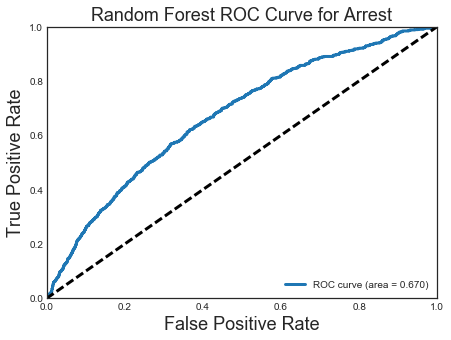

In [854]:
plt.figure(figsize=[7,5])
plt.plot(rfc_FPR[1], rfc_TPR[1], label='ROC curve (area = %0.3f)' % rfc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest ROC Curve for Arrest', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [767]:
print "Reports for Bagged Random Forest:\t", classifications(y_test, rfcb.predict(x_test))

Reports for Bagged Random Forest:	Mean accuracy score 0.779694237554  

[[3707  606]
 [ 518  271]] 

             precision    recall  f1-score   support

          0       0.88      0.86      0.87      4313
          1       0.31      0.34      0.33       789

avg / total       0.79      0.78      0.78      5102

None


In [771]:
rfcb_y_pred = rfcb.predict(x_test)
rfcb_cm = np.array(confusion_matrix(y_test, rfcb_y_pred))
rfcb_confusion = pd.DataFrame(rfcb_cm, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
rfcb_confusion

,predicted_no_arrest,predicted_arrest
no_arrest_actual,3707,606
arrest_actual,518,271


In [772]:
rfcb_y_score = rfcb.predict_proba(x_test)[:,1]

In [773]:
print roc_auc_score(y_test, rfcb_y_score)

0.676320329643


In [774]:
rfcb_FPR = dict()
rfcb_TPR = dict()
rfcb_ROC_AUC = dict()

In [775]:
rfcb_FPR[1], rfcb_TPR[1], _ = roc_curve(y_test, rfcb_y_score)
rfcb_ROC_AUC[1] = auc(rfcb_FPR[1], rfcb_TPR[1])

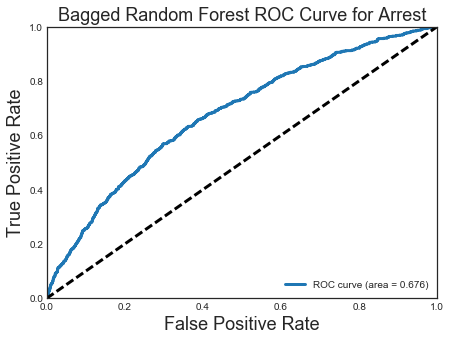

In [853]:
plt.figure(figsize=[7,5])
plt.plot(rfcb_FPR[1], rfcb_TPR[1], label='ROC curve (area = %0.3f)' % rfcb_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Bagged Random Forest ROC Curve for Arrest', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [777]:
print "Reports for Extra Trees:\t", classifications(y_test, et.predict(x_test))

Reports for Extra Trees:	Mean accuracy score 0.748137985104  

[[3516  797]
 [ 488  301]] 

             precision    recall  f1-score   support

          0       0.88      0.82      0.85      4313
          1       0.27      0.38      0.32       789

avg / total       0.78      0.75      0.76      5102

None


In [778]:
et_y_pred = et.predict(x_test)
et_cm = np.array(confusion_matrix(y_test, et_y_pred))
et_confusion = pd.DataFrame(et_cm, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
et_confusion

,predicted_no_arrest,predicted_arrest
no_arrest_actual,3516,797
arrest_actual,488,301


In [780]:
et_y_score = et.predict_proba(x_test)[:,1]

In [781]:
print roc_auc_score(y_test, et_y_score)

0.65682581355


In [784]:
et_FPR = dict()
et_TPR = dict()
et_ROC_AUC = dict()

In [785]:
et_FPR[1], et_TPR[1], _ = roc_curve(y_test, et_y_score)
et_ROC_AUC[1] = auc(et_FPR[1], et_TPR[1])

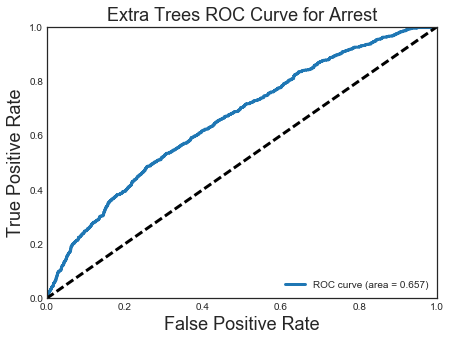

In [855]:
plt.figure(figsize=[7,5])
plt.plot(et_FPR[1], et_TPR[1], label='ROC curve (area = %0.3f)' % et_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Extra Trees ROC Curve for Arrest', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [856]:
print "Reports for Logistic Regression:\t", classifications(y_test, lr.predict(x_test))

Reports for Logistic Regression:	Mean accuracy score 0.645825166601  

[[2836 1477]
 [ 330  459]] 

             precision    recall  f1-score   support

          0       0.90      0.66      0.76      4313
          1       0.24      0.58      0.34       789

avg / total       0.79      0.65      0.69      5102

None


In [857]:
lr_y_pred = lr.predict(x_test)
lr_cm = np.array(confusion_matrix(y_test, lr_y_pred))
lr_confusion = pd.DataFrame(lr_cm, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
lr_confusion

,predicted_no_arrest,predicted_arrest
no_arrest_actual,2836,1477
arrest_actual,330,459


In [858]:
lr_y_score = lr.decision_function(x_test)

In [859]:
print roc_auc_score(y_test, lr_y_score)

0.64913309219


In [860]:
lr_FPR = dict()
lr_TPR = dict()
lr_ROC_AUC = dict()

In [861]:
lr_FPR[1], lr_TPR[1], _ = roc_curve(y_test, lr_y_score)
lr_ROC_AUC[1] = auc(lr_FPR[1], lr_TPR[1])

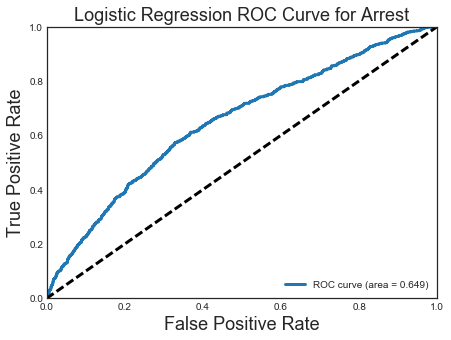

In [862]:
plt.figure(figsize=[7,5])
plt.plot(lr_FPR[1], lr_TPR[1], label='ROC curve (area = %0.3f)' % lr_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Logistic Regression ROC Curve for Arrest', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [863]:
print "Reports for Bagged Logistic Regression:\t", classifications(y_test, lrb.predict(x_test))

Reports for Bagged Logistic Regression:	Mean accuracy score 0.647589180713  

[[2857 1456]
 [ 342  447]] 

             precision    recall  f1-score   support

          0       0.89      0.66      0.76      4313
          1       0.23      0.57      0.33       789

avg / total       0.79      0.65      0.69      5102

None


In [864]:
lrb_y_pred = lrb.predict(x_test)
lrb_cm = np.array(confusion_matrix(y_test, lrb_y_pred))
lrb_confusion = pd.DataFrame(lrb_cm, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
lrb_confusion

,predicted_no_arrest,predicted_arrest
no_arrest_actual,2857,1456
arrest_actual,342,447


In [865]:
lrb_y_score = lrb.decision_function(x_test)

In [866]:
print roc_auc_score(y_test, lrb_y_score)

0.648548894388


In [867]:
lrb_FPR = dict()
lrb_TPR = dict()
lrb_ROC_AUC = dict()

In [868]:
lrb_FPR[1], lrb_TPR[1], _ = roc_curve(y_test, lrb_y_score)
lrb_ROC_AUC[1] = auc(lrb_FPR[1], lrb_TPR[1])

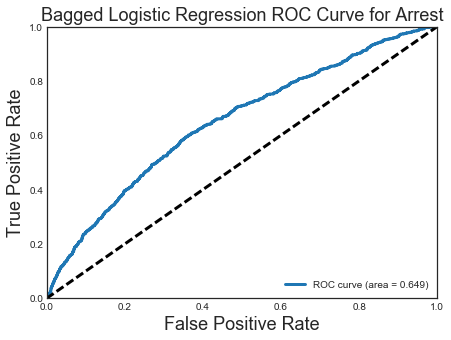

In [869]:
plt.figure(figsize=[7,5])
plt.plot(lrb_FPR[1], lrb_TPR[1], label='ROC curve (area = %0.3f)' % lrb_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Bagged Logistic Regression ROC Curve for Arrest', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [870]:
print "Reports for Voting Classifier:\t", classifications(y_test, vc.predict(x_test))

Reports for Voting Classifier:	Mean accuracy score 0.809290474324  

[[3948  365]
 [ 608  181]] 

             precision    recall  f1-score   support

          0       0.87      0.92      0.89      4313
          1       0.33      0.23      0.27       789

avg / total       0.78      0.81      0.79      5102

None


In [871]:
vc_y_pred = vc.predict(x_test)
vc_cm = np.array(confusion_matrix(y_test, vc_y_pred))
vc_confusion = pd.DataFrame(vc_cm, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
vc_confusion

,predicted_no_arrest,predicted_arrest
no_arrest_actual,3948,365
arrest_actual,608,181


In [872]:
vc_y_score = vc.predict_proba(x_test)[:,1]

In [873]:
print roc_auc_score(y_test, vc_y_score)

0.675481353423


In [874]:
vc_FPR = dict()
vc_TPR = dict()
vc_ROC_AUC = dict()

In [875]:
roc_curve(y_test, vc_y_score)

(array([  0.00000000e+00,   2.31857176e-04,   6.95571528e-04, ...,
          9.90030141e-01,   9.90030141e-01,   1.00000000e+00]),
 array([ 0.        ,  0.        ,  0.        , ...,  0.99873257,
         1.        ,  1.        ]),
 array([ 1.77488209,  0.77488209,  0.75719998, ...,  0.12108653,
         0.12103679,  0.07757145]))

In [876]:
vc_FPR[1], vc_TPR[1], _ = roc_curve(y_test, vc_y_score)
vc_ROC_AUC[1] = auc(vc_FPR[1], vc_TPR[1])

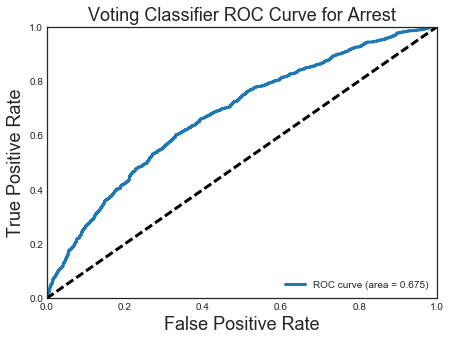

In [877]:
plt.figure(figsize=[7,5])
plt.plot(vc_FPR[1], vc_TPR[1], label='ROC curve (area = %0.3f)' % vc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Voting Classifier ROC Curve for Arrest', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [878]:
print "Reports for Voting Classifier 2:\t", classifications(y_test, vc2.predict(x_test))

Reports for Voting Classifier 2:	Mean accuracy score 0.782438259506  

[[3731  582]
 [ 528  261]] 

             precision    recall  f1-score   support

          0       0.88      0.87      0.87      4313
          1       0.31      0.33      0.32       789

avg / total       0.79      0.78      0.79      5102

None


In [879]:
vc2_y_pred = vc2.predict(x_test)
vc2_cm = np.array(confusion_matrix(y_test, vc2_y_pred))
vc2_confusion = pd.DataFrame(vc2_cm, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
vc2_confusion

,predicted_no_arrest,predicted_arrest
no_arrest_actual,3731,582
arrest_actual,528,261


In [880]:
vc2_y_score = vc2.predict_proba(x_test)[:,1]

In [881]:
print roc_auc_score(y_test, vc2_y_score)

0.67456538534


In [882]:
vc2_FPR = dict()
vc2_TPR = dict()
vc2_ROC_AUC = dict()

In [883]:
roc_curve(y_test, vc2_y_score)

(array([  0.00000000e+00,   2.31857176e-04,   6.95571528e-04, ...,
          9.83769998e-01,   9.83769998e-01,   1.00000000e+00]),
 array([ 0.        ,  0.        ,  0.        , ...,  0.99873257,
         1.        ,  1.        ]),
 array([ 1.81035801,  0.81035801,  0.76925337, ...,  0.14812824,
         0.14780061,  0.08384177]))

In [884]:
vc2_FPR[1], vc2_TPR[1], _ = roc_curve(y_test, vc2_y_score)
vc2_ROC_AUC[1] = auc(vc2_FPR[1], vc2_TPR[1])

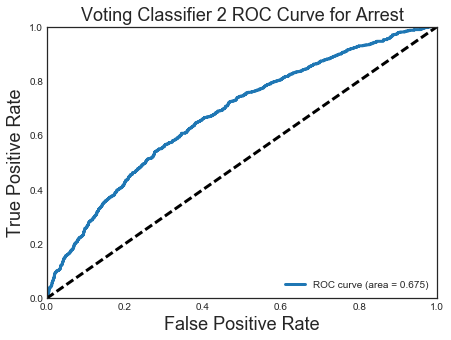

In [885]:
plt.figure(figsize=[7,5])
plt.plot(vc2_FPR[1], vc2_TPR[1], label='ROC curve (area = %0.3f)' % vc2_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Voting Classifier 2 ROC Curve for Arrest', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [886]:
print "Reports for Voting Classifier 3:\t", classifications(y_test, vc3.predict(x_test))

Reports for Voting Classifier 3:	Mean accuracy score 0.726577812623  

[[3337  976]
 [ 419  370]] 

             precision    recall  f1-score   support

          0       0.89      0.77      0.83      4313
          1       0.27      0.47      0.35       789

avg / total       0.79      0.73      0.75      5102

None


In [887]:
vc3_y_pred = vc3.predict(x_test)
vc3_cm = np.array(confusion_matrix(y_test, vc3_y_pred))
vc3_confusion = pd.DataFrame(vc3_cm, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
vc3_confusion

,predicted_no_arrest,predicted_arrest
no_arrest_actual,3337,976
arrest_actual,419,370


In [888]:
vc3_y_score = vc3.predict_proba(x_test)[:,1]

In [889]:
print roc_auc_score(y_test, vc3_y_score)

0.672951494832


In [890]:
vc3_FPR = dict()
vc3_TPR = dict()
vc3_ROC_AUC = dict()

In [891]:
roc_curve(y_test, vc3_y_score)

(array([  0.00000000e+00,   2.31857176e-04,   9.27428704e-04, ...,
          9.81683283e-01,   9.81683283e-01,   1.00000000e+00]),
 array([ 0.        ,  0.        ,  0.        , ...,  0.99873257,
         1.        ,  1.        ]),
 array([ 1.82536647,  0.82536647,  0.80115138, ...,  0.163649  ,
         0.16332623,  0.0949523 ]))

In [892]:
vc3_FPR[1], vc3_TPR[1], _ = roc_curve(y_test, vc3_y_score)
vc3_ROC_AUC[1] = auc(vc3_FPR[1], vc3_TPR[1])

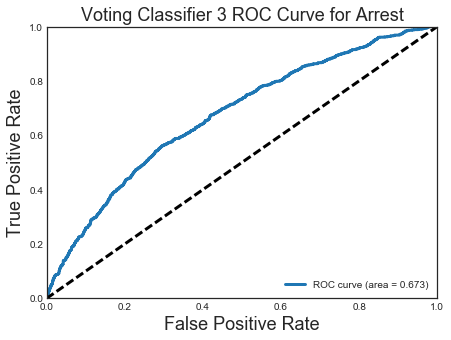

In [893]:
plt.figure(figsize=[7,5])
plt.plot(vc3_FPR[1], vc3_TPR[1], label='ROC curve (area = %0.3f)' % vc3_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Voting Classifier 3 ROC Curve for Arrest', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [894]:
print "Reports for Voting Classifier 4:\t", classifications(y_test, vc4.predict(x_test))

Reports for Voting Classifier 4:	Mean accuracy score 0.740493923951  

[[3454  859]
 [ 465  324]] 

             precision    recall  f1-score   support

          0       0.88      0.80      0.84      4313
          1       0.27      0.41      0.33       789

avg / total       0.79      0.74      0.76      5102

None


In [895]:
vc4_y_pred = vc4.predict(x_test)
vc4_cm = np.array(confusion_matrix(y_test, vc4_y_pred))
vc4_confusion = pd.DataFrame(vc4_cm, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
vc4_confusion

,predicted_no_arrest,predicted_arrest
no_arrest_actual,3454,859
arrest_actual,465,324


In [896]:
vc4_y_score = vc4.predict_proba(x_test)[:,1]

In [897]:
print roc_auc_score(y_test, vc4_y_score)

0.674952695553


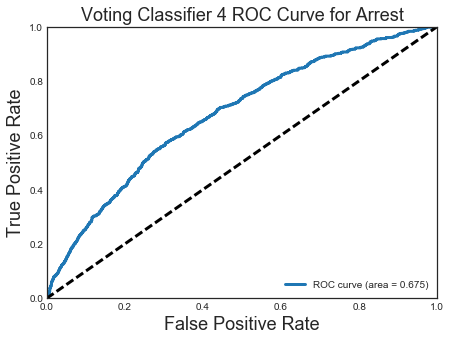

In [898]:
vc4_FPR = dict()
vc4_TPR = dict()
vc4_ROC_AUC = dict()

roc_curve(y_test, vc4_y_score)  #will give arrays

vc4_FPR[1], vc4_TPR[1], _ = roc_curve(y_test, vc4_y_score)
vc4_ROC_AUC[1] = auc(vc4_FPR[1], vc4_TPR[1])

#Plotting
plt.figure(figsize=[7,5])
plt.plot(vc4_FPR[1], vc4_TPR[1], label='ROC curve (area = %0.3f)' % vc4_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Voting Classifier 4 ROC Curve for Arrest', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [899]:
print "Reports for Voting Classifier 5:\t", classifications(y_test, vc5.predict(x_test))

Reports for Voting Classifier 5:	Mean accuracy score 0.765778126225  

[[3626  687]
 [ 508  281]] 

             precision    recall  f1-score   support

          0       0.88      0.84      0.86      4313
          1       0.29      0.36      0.32       789

avg / total       0.79      0.77      0.78      5102

None


In [900]:
vc5_y_pred = vc5.predict(x_test)
vc5_cm = np.array(confusion_matrix(y_test, vc5_y_pred))
vc5_confusion = pd.DataFrame(vc5_cm, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
vc5_confusion

,predicted_no_arrest,predicted_arrest
no_arrest_actual,3626,687
arrest_actual,508,281


In [901]:
vc5_y_score = vc5.predict_proba(x_test)[:,1]

In [902]:
print roc_auc_score(y_test, vc5_y_score)

0.67791864546


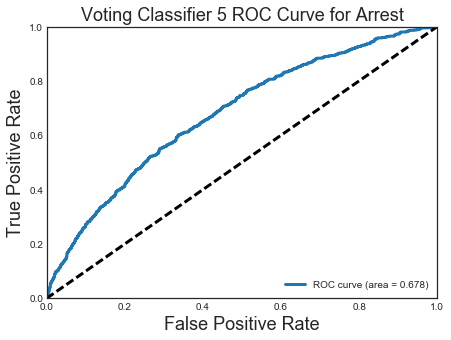

In [903]:
vc5_FPR = dict()
vc5_TPR = dict()
vc5_ROC_AUC = dict()

roc_curve(y_test, vc5_y_score)  #will give arrays

vc5_FPR[1], vc5_TPR[1], _ = roc_curve(y_test, vc5_y_score)
vc5_ROC_AUC[1] = auc(vc5_FPR[1], vc5_TPR[1])

#Plotting
plt.figure(figsize=[7,5])
plt.plot(vc5_FPR[1], vc5_TPR[1], label='ROC curve (area = %0.3f)' % vc5_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Voting Classifier 5 ROC Curve for Arrest', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [904]:
print "Reports for Voting Classifier 6:\t", classifications(y_test, vc6.predict(x_test))

Reports for Voting Classifier 6:	Mean accuracy score 0.736181889455  

[[3406  907]
 [ 439  350]] 

             precision    recall  f1-score   support

          0       0.89      0.79      0.84      4313
          1       0.28      0.44      0.34       789

avg / total       0.79      0.74      0.76      5102

None


In [905]:
vc6_y_pred = vc6.predict(x_test)
vc6_cm = np.array(confusion_matrix(y_test, vc6_y_pred))
vc6_confusion = pd.DataFrame(vc6_cm, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
vc6_confusion

,predicted_no_arrest,predicted_arrest
no_arrest_actual,3406,907
arrest_actual,439,350


In [906]:
vc6_y_score = vc6.predict_proba(x_test)[:, 1]

In [907]:
print roc_auc_score(y_test, vc6_y_score)

0.674010573745


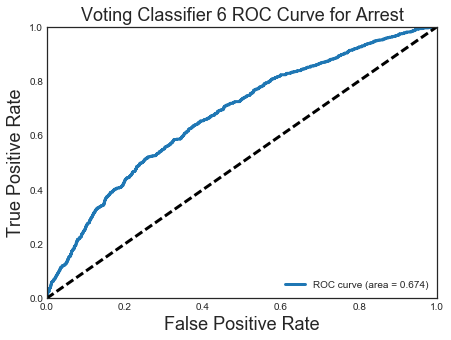

In [908]:
vc6_FPR = dict()
vc6_TPR = dict()
vc6_ROC_AUC = dict()

roc_curve(y_test, vc6_y_score)  #will give arrays

vc6_FPR[1], vc6_TPR[1], _ = roc_curve(y_test, vc6_y_score)
vc6_ROC_AUC[1] = auc(vc6_FPR[1], vc6_TPR[1])

#Plotting
plt.figure(figsize=[7,5])
plt.plot(vc6_FPR[1], vc6_TPR[1], label='ROC curve (area = %0.3f)' % vc6_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Voting Classifier 6 ROC Curve for Arrest', fontsize=18)
plt.legend(loc="lower right")
plt.show()

MANIPULATING THRESHOLDS

In [651]:
df_predictions = pd.DataFrame(rfcb.predict_proba(x_test), columns=['class_0_prediction','class_1_prediction'])
print(df_predictions.iloc[0:10])

   class_0_prediction  class_1_prediction
0            0.602301            0.397699
1            0.558258            0.441742
2            0.694309            0.305691
3            0.733623            0.266377
4            0.631127            0.368873
5            0.738058            0.261942
6            0.695637            0.304363
7            0.447983            0.552017
8            0.590419            0.409581
9            0.639363            0.360637


In [652]:
df_predictions['prediction_class_thresh50'] = rfcb_y_pred
print(df_predictions.iloc[0:10])

   class_0_prediction  class_1_prediction  prediction_class_thresh50
0            0.602301            0.397699                          0
1            0.558258            0.441742                          0
2            0.694309            0.305691                          0
3            0.733623            0.266377                          0
4            0.631127            0.368873                          0
5            0.738058            0.261942                          0
6            0.695637            0.304363                          0
7            0.447983            0.552017                          1
8            0.590419            0.409581                          0
9            0.639363            0.360637                          0


In [653]:
df_predictions['prediction_class_thresh40'] = [1 if x >= 0.40 else 0 for x in df_predictions.class_1_prediction.values]
print(y_pp.iloc[0:10])

   class_0_pp  class_1_pp  pred_class_thresh50  pred_class_thresh40  \
0    0.782410    0.217590                    0                    0   
1    0.606180    0.393820                    0                    0   
2    0.666631    0.333369                    0                    0   
3    0.699214    0.300786                    0                    0   
4    0.652911    0.347089                    0                    0   
5    0.693497    0.306503                    0                    0   
6    0.864404    0.135596                    0                    0   
7    0.743375    0.256625                    0                    0   
8    0.690500    0.309500                    0                    0   
9    0.732543    0.267457                    0                    0   

   pred_class_thresh35  pred_class_thresh45  
0                    0                    0  
1                    1                    0  
2                    0                    0  
3                    0            

In [654]:
df_predictions['pred_class_thresh35'] = [1 if x >= 0.35 else 0 for x in df_predictions.class_1_prediction.values]
print df_predictions.iloc[0:10]

   class_0_prediction  class_1_prediction  prediction_class_thresh50  \
0            0.602301            0.397699                          0   
1            0.558258            0.441742                          0   
2            0.694309            0.305691                          0   
3            0.733623            0.266377                          0   
4            0.631127            0.368873                          0   
5            0.738058            0.261942                          0   
6            0.695637            0.304363                          0   
7            0.447983            0.552017                          1   
8            0.590419            0.409581                          0   
9            0.639363            0.360637                          0   

   prediction_class_thresh40  pred_class_thresh35  
0                          0                    1  
1                          1                    1  
2                          0                    0  

In [655]:
df_predictions['pred_class_thresh45'] = [1 if x >= 0.45 else 0 for x in df_predictions.class_1_prediction.values]
print df_predictions.iloc[0:10]

   class_0_prediction  class_1_prediction  prediction_class_thresh50  \
0            0.602301            0.397699                          0   
1            0.558258            0.441742                          0   
2            0.694309            0.305691                          0   
3            0.733623            0.266377                          0   
4            0.631127            0.368873                          0   
5            0.738058            0.261942                          0   
6            0.695637            0.304363                          0   
7            0.447983            0.552017                          1   
8            0.590419            0.409581                          0   
9            0.639363            0.360637                          0   

   prediction_class_thresh40  pred_class_thresh35  pred_class_thresh45  
0                          0                    1                    0  
1                          1                    1            

In [656]:
matrix45 = np.array(confusion_matrix(y_test, df_predictions.pred_class_thresh45.values))
confusion45 = pd.DataFrame(matrix45, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
confusion45

,predicted_no_arrest,predicted_arrest
no_arrest_actual,3250,1025
arrest_actual,419,408


In [657]:
print "Reports for Bagged Random Forest:\t", classifications(y_test, df_predictions.pred_class_thresh45.values)

Reports for Bagged Random Forest:	Mean accuracy score 0.71697373579  

[[3250 1025]
 [ 419  408]] 

             precision    recall  f1-score   support

          0       0.89      0.76      0.82      4275
          1       0.28      0.49      0.36       827

avg / total       0.79      0.72      0.74      5102

None


In [658]:
print roc_auc_score(y_test, df_predictions.pred_class_thresh45.values)

0.626791686997


In [659]:
matrix40 = np.array(confusion_matrix(y_test, df_predictions.pred_class_thresh40.values))
confusion40 = pd.DataFrame(matrix40, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
confusion40

AttributeError: 'DataFrame' object has no attribute 'pred_class_thresh40'

In [ ]:
# matrix40 = np.array(confusion_matrix(y_test, df_predictions.pred_class_thresh40.values))
# confusion40 = pd.DataFrame(matrix40, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
# confusion40

In [ ]:
print roc_auc_score(y_test, df_predictions.pred_class_thresh40.values)

In [ ]:
matrix35 = np.array(confusion_matrix(y_test, y_pp.pred_class_thresh35.values))
confusion35 = pd.DataFrame(matrix35, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
confusion35

In [ ]:
print "Reports for LR:\t", classifications(y_test, lr.predict(x_test))

In [ ]:
print "Reports for GBC:\t", classifications(y_test, gbc.predict(x_test))

In [ ]:
print "Reports for AB:\t", classifications(y_test, ab.predict(x_test))

In [ ]:
ab_y_pred = ab.predict(x_test)
ab_matrix = np.array(confusion_matrix(y_test, ab_y_pred ))
ab_confusion = pd.DataFrame(ab_matrix, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
ab_confusion

In [ ]:
rfc_y_pred = rfc.predict(x_test)
rfc_matrix = np.array(confusion_matrix(y_test, rfc_y_pred ))
rfc_confusion = pd.DataFrame(rfc_matrix, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
rfc_confusion

In [ ]:
def classifications(y_test, y_predict):
    print 'Mean accuracy score %s ' % accuracy_score(y_test, y_predict), '\n'
    print confusion_matrix(y_test, y_predict), '\n'
    print classification_report(y_test, y_predict)

In [ ]:
print "Reports for RFC:\t", classifications(y_test, rfc.predict(x_test))

In [ ]:
et_y_pred = et.predict(x_test)
et_matrix = np.array(confusion_matrix(y_test, et_y_pred ))
et_confusion = pd.DataFrame(et_matrix, index=['no_arrest_actual', 'arrest_actual'], columns=['predicted_no_arrest', 'predicted_arrest'])
et_confusion

In [ ]:
print "Reports for ET:\t", classifications(y_test, et.predict(x_test))